<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import random
from IPython import display
import copy
import time
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from torchvision import transforms as tfs
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt", images_name = "lfw-deepfunneled", cropsize=110, rescale=64):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("gdown http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("gdown http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    transform = tfs.Compose([
                              tfs.CenterCrop(cropsize),
                              tfs.Resize(rescale, interpolation=tfs.InterpolationMode.BOX),
                              tfs.ToTensor(),
                            ])

    def preprocess(img):
        img = Image.open(img)
        img.load()
        return transform(img)

    all_photos =df['photo_path'].apply(preprocess)

    all_photos = torch.Tensor(np.stack(all_photos.values))#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=50, shuffle=False)

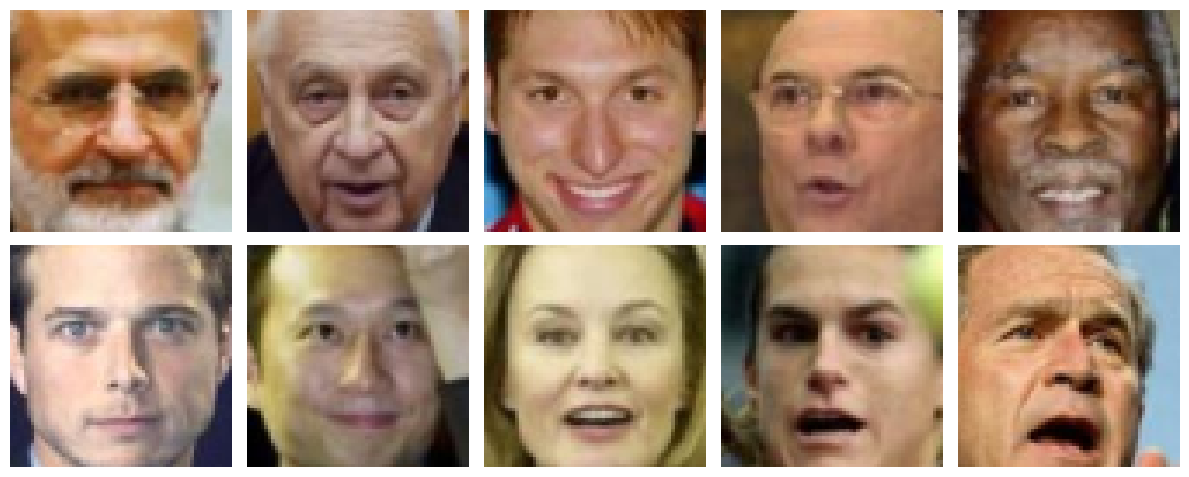

In [ ]:
# Визуализируем 10 случайных изображений из датасета
fig,ax = plt.subplots(2,5,figsize=(12,5))
axr = ax.ravel()
idxs = np.random.randint(0,len(data),10)
for i,ax in enumerate(axr):
    ax.imshow(data[idxs[i]].permute((1,2,0)))
    ax.axis('off')
plt.tight_layout()

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class LinearAE(nn.Module):
    def __init__(self, latent_dim):
        # Обратите внимание на формат, в котором функция fetch() возвращает data
        super(LinearAE,self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64,self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim,3*64*64),
            nn.Unflatten(1,(3,64,64)),
            nn.Sigmoid()
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [ ]:
class ConvAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.Conv2d(64,128,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(128*16*16,self.latent_dim)

        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128*16*16),
            nn.PReLU(),
            nn.Unflatten(1,(128,16,16)),
            nn.ConvTranspose2d(128,64,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.ConvTranspose2d(64,64, kernel_size=2, stride=2),
            nn.PReLU(),
            nn.Conv2d(64,3,kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None) -> pd.DataFrame:

    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        X_viz = next(iter(data_val))
        fig = plt.figure(figsize=(25,5), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(2, 5)
        gs01 = gs0[1].subgridspec(2, 5)
        for a in range(2):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );
        pbar = range(epochs)
    else:

        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:
        avg_train_loss = 0
        avg_val_loss = 0

        model.train()
        for X_batch in data_tr:
            X_batch = X_batch.to(device)
            opt.zero_grad()
            Y_pred,_ = model(X_batch)
            loss =  loss_fn(Y_pred, X_batch)
            loss.backward()
            opt.step()

            avg_train_loss += loss / len(data_tr)

        model.eval()
        with torch.no_grad():
            for X_val_batch in data_val:
                X_val_batch = X_val_batch.to(device)
                Y_val_pred,_ = model(X_val_batch)
                val_loss =  loss_fn(Y_val_pred, X_val_batch)
                avg_val_loss += val_loss / len(data_val)

        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())

        Y_pred.cpu()
        Y_val_pred.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_val_batch.cpu()
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()

        model.eval()
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz.to(device))[0].detach().cpu()
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[k].permute((1,2,0)))
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(Y_hat[k].permute((1,2,0)))
                fig.axes[k+5].set_title('Reconstructed')
                fig.axes[k+5].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        display.clear_output(wait=True)

    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

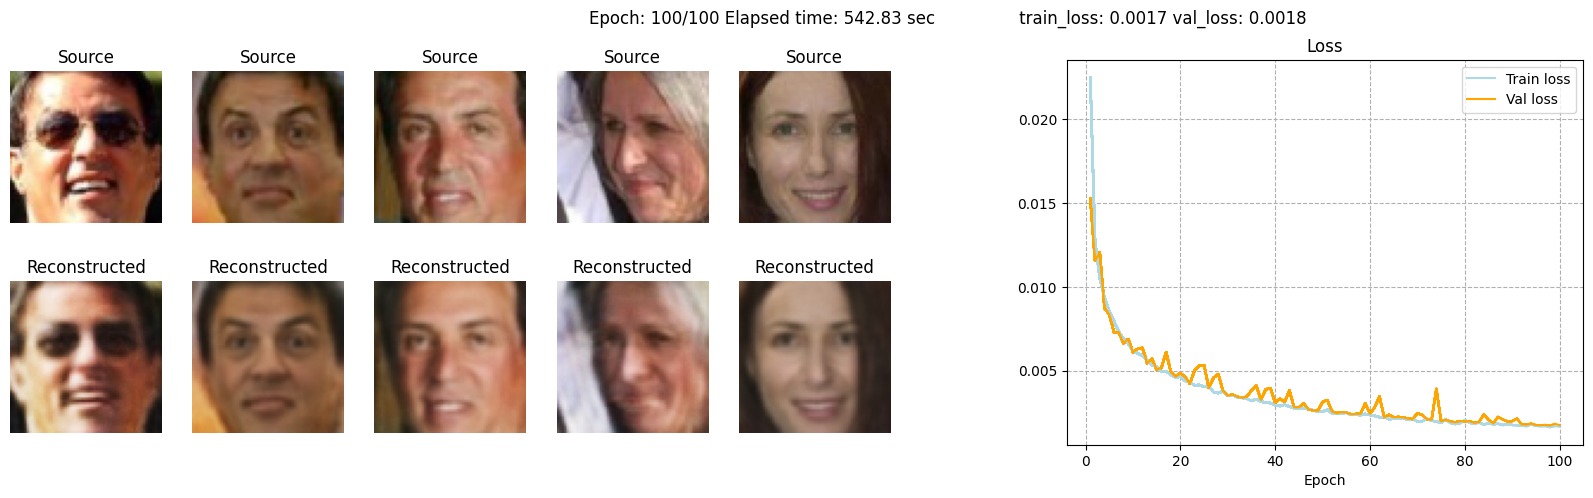

In [ ]:
criterion = nn.MSELoss()
linear_ae = LinearAE(512)
linear_ae_optimizer = torch.optim.AdamW(linear_ae.parameters(), lr=3e-4, amsgrad=True)
linear_ae_history = train(model=linear_ae, opt=linear_ae_optimizer, loss_fn=criterion, epochs=100, data_tr=train_loader, data_val=val_loader, viz=True, scheduler=None)

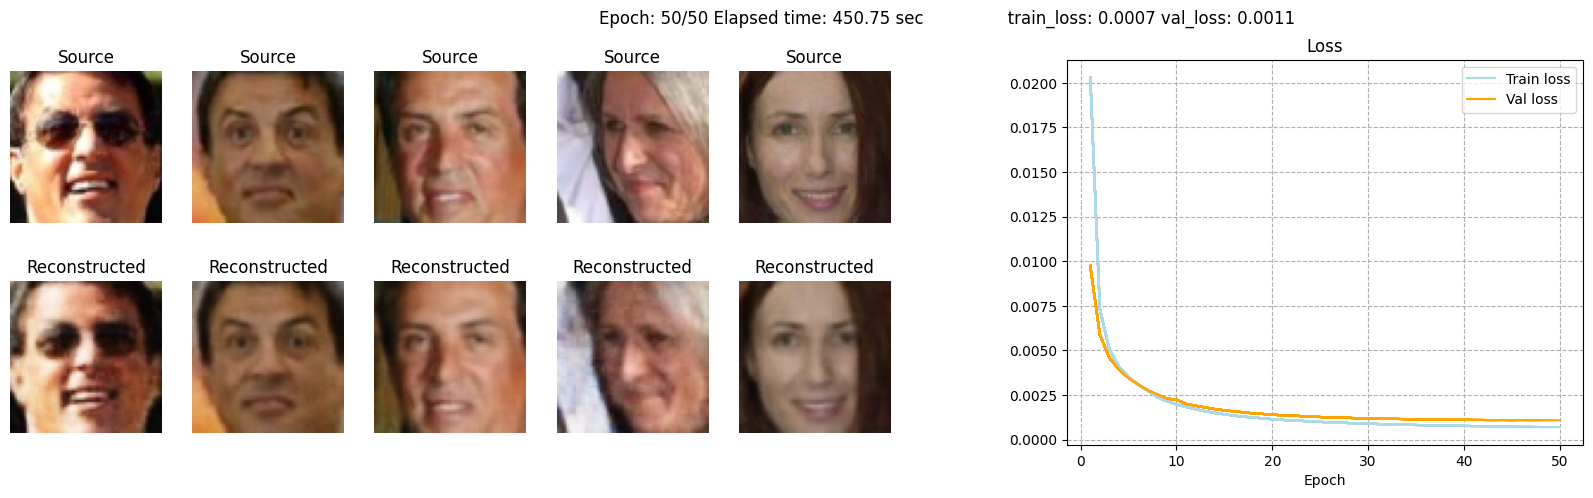

In [ ]:
criterion = nn.MSELoss()
conv_ae = ConvAE(512)
conv_ae_optimizer = torch.optim.AdamW(conv_ae.parameters(), lr=3e-4, amsgrad=True)
conv_ae_history = train(model=conv_ae, opt=conv_ae_optimizer, loss_fn=criterion, epochs=50, data_tr=train_loader, data_val=val_loader, viz=True, scheduler=None)

Not bad, right?

In [ ]:
def visualize(model, data, num_imgs):
    idxs = np.random.randint(0,len(val_photos),num_imgs)
    encoded,_ = model(data[idxs])
    fig,ax = plt.subplots(2,num_imgs, figsize=(num_imgs*2+2,5))
    for i in range(len(idxs)):
        ax[0,i].imshow(data[idxs][i].permute((1,2,0)))
        ax[0,i].set_title('Source')
        ax[0,i].axis('off')
        ax[1,i].imshow(encoded[i].detach().permute((1,2,0)))
        ax[1,i].set_title('Reconstructed')
        ax[1,i].axis('off')
    plt.tight_layout();

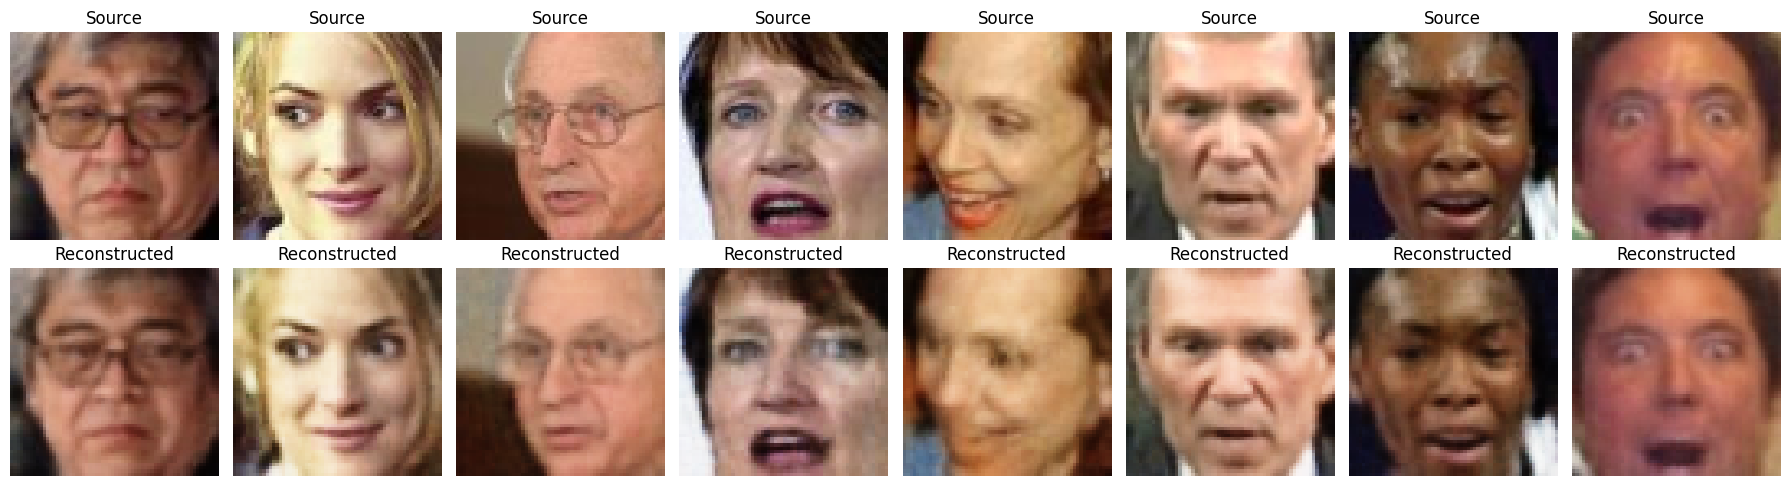

In [ ]:
visualize(conv_ae, val_photos, 8)

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
all_vecs = torch.FloatTensor()
with torch.no_grad():
    conv_ae.to(device)
    conv_ae.eval()
    for batch in train_loader:
        batch = batch.to(device)
        lat = conv_ae.encoder(batch)
        all_vecs = torch.cat((all_vecs,lat.cpu()))
        batch.cpu()
        del batch
        torch.cuda.empty_cache()
    conv_ae.cpu()

latent_mean = all_vecs.mean(axis=0)
latent_std = all_vecs.std(axis=0)

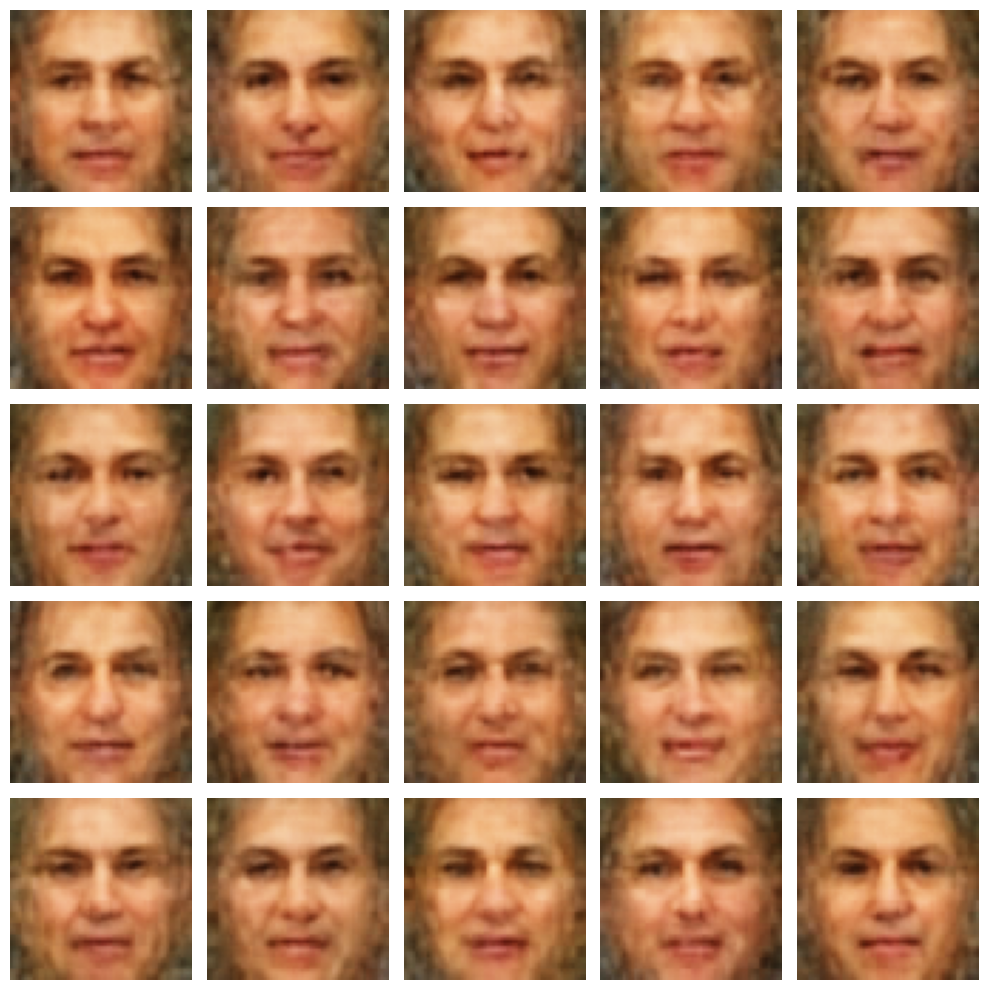

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(25, 512))
z = z*latent_std*.4 + latent_mean*2
output = conv_ae.decoder(torch.FloatTensor(z))
fig,ax = plt.subplots(5,5,figsize=(10,10))
axr = ax.ravel()
for i in range(len(z)):
    axr[i].imshow(output[i].detach().permute((1,2,0)))
    axr[i].axis('off')
plt.tight_layout()

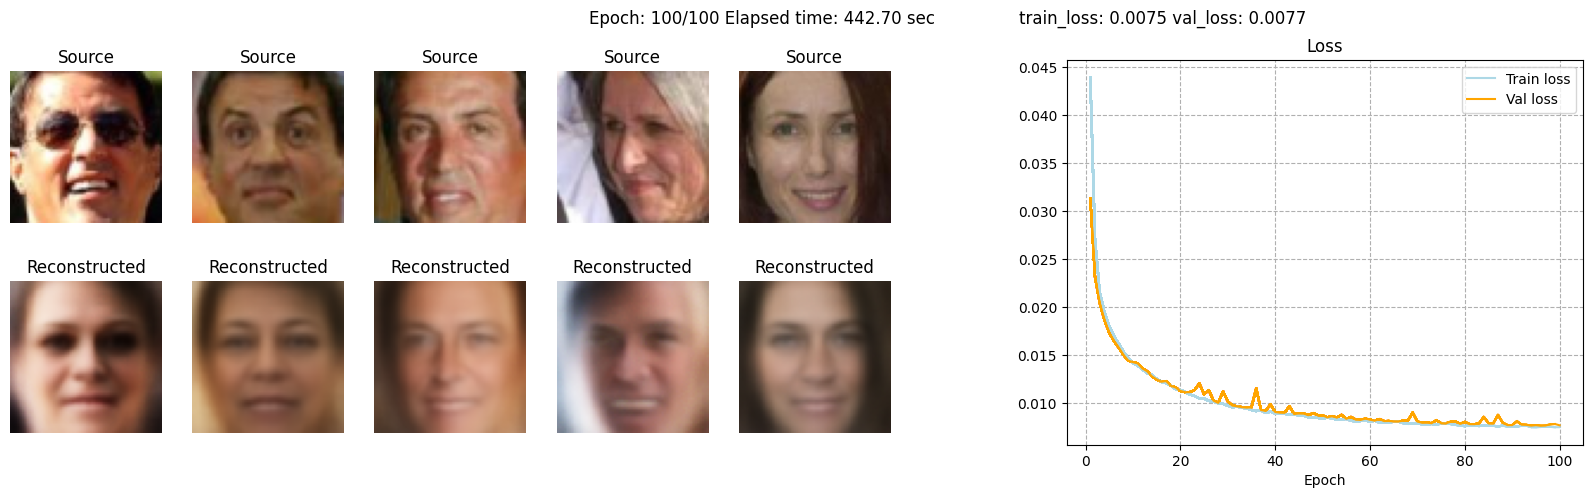

In [ ]:
criterion = nn.MSELoss()
linear_ae_32 = LinearAE(32)
linear_ae_32_optimizer = torch.optim.AdamW(linear_ae_32.parameters(), lr=3e-4, amsgrad=True)
linear_ae_32_history = train(model=linear_ae_32, opt=linear_ae_32_optimizer, loss_fn=criterion, epochs=100, data_tr=train_loader, data_val=val_loader, viz=True, scheduler=None)

In [ ]:
all_32_vecs = torch.FloatTensor()
with torch.no_grad():
    linear_ae_32.to(device)
    linear_ae_32.eval()
    for batch in train_loader:
        batch = batch.to(device)
        lat = linear_ae_32.encoder(batch)
        all_32_vecs = torch.cat((all_32_vecs,lat.cpu()))
        batch.cpu()
        del batch
        torch.cuda.empty_cache()
    linear_ae_32.cpu()

latent_32_mean = all_32_vecs.mean(axis=0)
latent_32_std = all_32_vecs.std(axis=0)

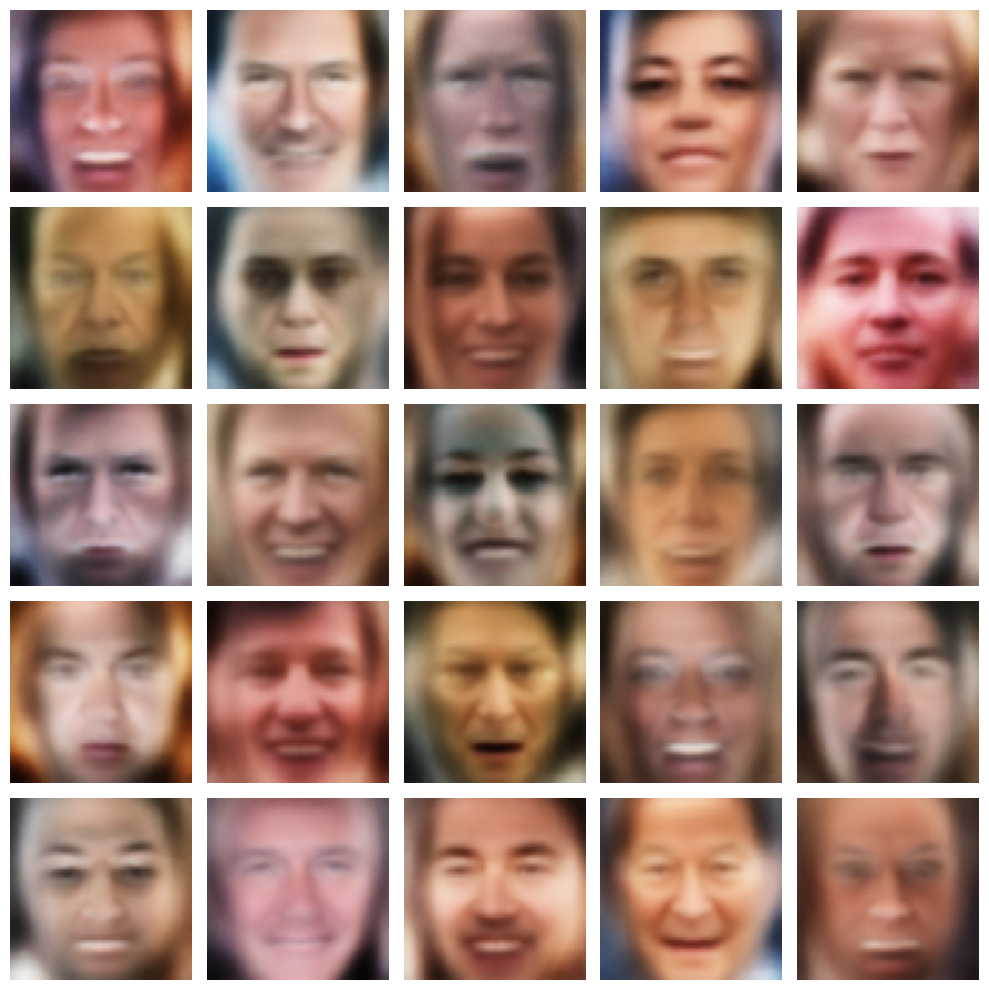

In [ ]:
z = torch.FloatTensor(np.random.randn(25, 32))
z = z*latent_32_std + latent_32_mean
output = linear_ae_32.decoder(torch.FloatTensor(z))
fig,ax = plt.subplots(5,5,figsize=(10,10))
axr = ax.ravel()
for i in range(len(z)):
    axr[i].imshow(output[i].detach().permute((1,2,0)))
    axr[i].axis('off')
plt.tight_layout()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
def get_vecs(model, data):
    model.to(device)
    model.eval()
    vecs = torch.FloatTensor()
    with torch.no_grad():
        for batch in data:
            batch = batch.to(device)
            lat = model.encoder(batch)
            vecs = torch.cat((vecs,lat.cpu()))
            batch.cpu()
            del batch
        model.cpu()
        torch.cuda.empty_cache()
    return vecs

In [ ]:
smiling_idxs = train_attrs['Smiling'].sort_values(ascending=False)[:1000].index.values
grumpy_idxs = train_attrs['Smiling'].sort_values(ascending=True)[:1000].index.values
neutral_idxs = train_attrs[(train_attrs['Smiling'] > -.2) & (train_attrs['Smiling'] < .2)]['Smiling'][:1000].index.values

smiling_loader =  torch.utils.data.DataLoader(train_photos[smiling_idxs], batch_size=50, shuffle=False)
grumpy_loader =  torch.utils.data.DataLoader(train_photos[grumpy_idxs], batch_size=50, shuffle=False)
neutral_loader =  torch.utils.data.DataLoader(train_photos[neutral_idxs], batch_size=50, shuffle=False)

smiling_mean = (get_vecs(conv_ae,smiling_loader)).mean(axis=0)
grumpy_mean = (get_vecs(conv_ae,grumpy_loader)).mean(axis=0)
neutral_mean = (get_vecs(conv_ae,neutral_loader)).mean(axis=0)

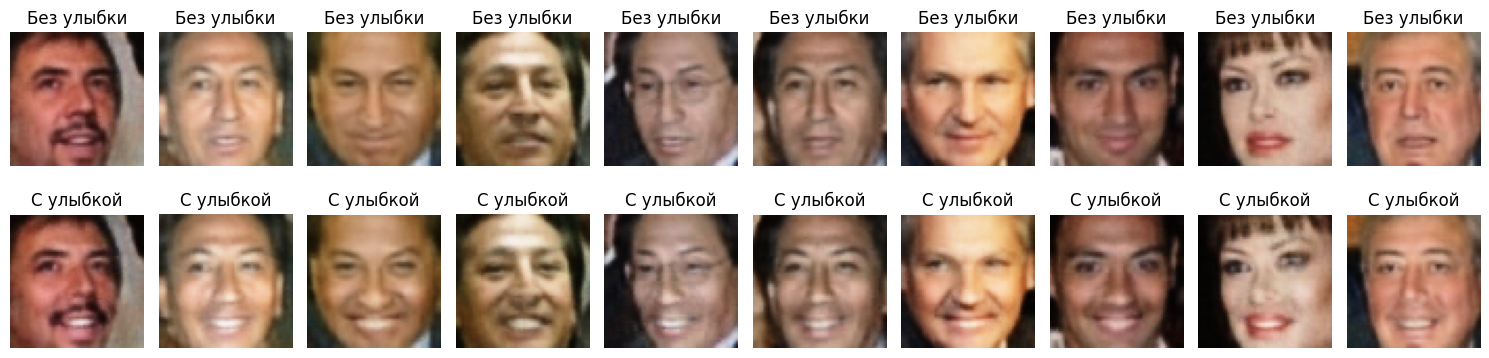

In [ ]:
smile_vector = smiling_mean-grumpy_mean

neutral_test = conv_ae.encoder(next(iter(neutral_loader)))[26:36]
neutral_plus_smile = neutral_test+smile_vector

with torch.no_grad():
    source = conv_ae.decoder(neutral_test)
    adjusted = conv_ae.decoder(neutral_plus_smile)

fig,ax = plt.subplots(2,10,figsize=(15,4))
axr = ax.ravel()
for i in range(10):
    axr[i].imshow(source[i].permute((1,2,0)))
    axr[i].axis('off')
    axr[i].set_title('Без улыбки')
    axr[i+10].imshow(adjusted[i].permute((1,2,0)))
    axr[i+10].axis('off')
    axr[i+10].set_title('С улыбкой')
plt.tight_layout()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)